In [7]:
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [17]:
import sys

custom_modules = [mod for mod in sys.modules if mod.startswith('utils.') or mod.startswith('neuronModels.')]
for module in custom_modules:
    del sys.modules[module]
from neuronModels.FitzhughNagumoModel import FitzhughNagumoModel
from neuronModels.GRUNetwork import GRUNetwork
from neuronModels.HybridModel import HybridModel
from neuronModels.IzhikevichModel import izhikevich_model
from neuronModels.LifModel import LifModel
from utils.Constants import Constants
from utils.DataHandler import DataHandler
from utils.Logger import Logger, LogLevel
from utils.Plotter import Plotter

logger = Logger()
logger.log("Librerie Buildate", LogLevel.INFO)

[2025-03-15 11:02:26] [INFO] Librerie Buildate


Dati di banchmark articolo [1]:


In [13]:

# Calculate adjacency matrix G using Kronecker product
G = DataHandler.generate_adjacency_matrix(Constants.A1, n=3)

In [14]:
# FitzHugh-Nagumo Model
hybrid_model = HybridModel()
fn_model = FitzhughNagumoModel(Constants.N, Constants.EPSILON, Constants.SIGMA, Constants.A, Constants.B, G)

t,sol = fn_model._generate_synthetic_data()
logger.log("Generated synthetic data for FitzHugh-Nagumo model")

[2025-03-15 11:01:35] [INFO] Generated synthetic data for FitzHugh-Nagumo model


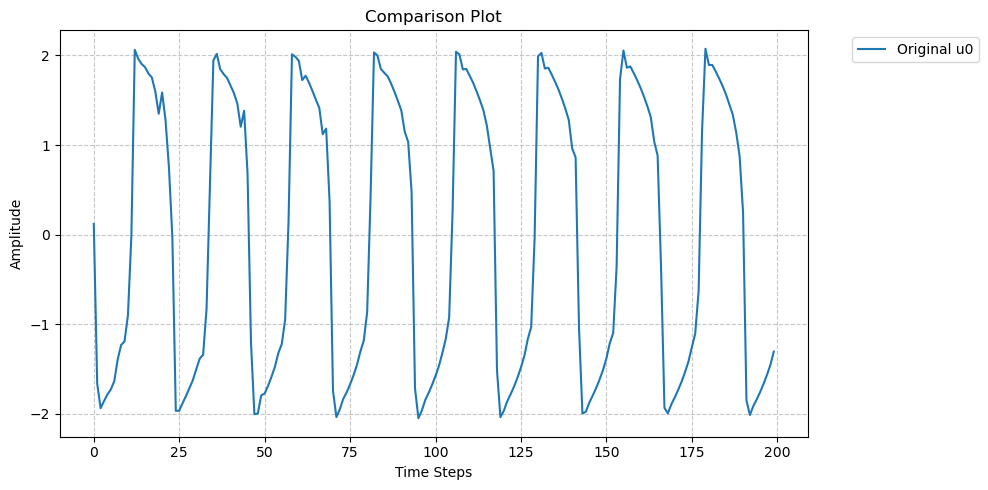

In [15]:

Plotter.plot_data(sol, num_series=1, time_steps=200, var_name='u')

In [18]:

x,y = DataHandler._prepare_data(sol)
x_train, y_train, x_test, y_test = DataHandler._split_train_test(x,y)

In [19]:

model = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 200 )
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)


Epoch [20/200], Train Loss: 0.0402 
Epoch [40/200], Train Loss: 0.0193 
Epoch [60/200], Train Loss: 0.0115 
Epoch [80/200], Train Loss: 0.0082 
Epoch [100/200], Train Loss: 0.0054 
Epoch [120/200], Train Loss: 0.0043 
Epoch [140/200], Train Loss: 0.0037 
Epoch [160/200], Train Loss: 0.0049 
Epoch [180/200], Train Loss: 0.0030 
Epoch [200/200], Train Loss: 0.0027 


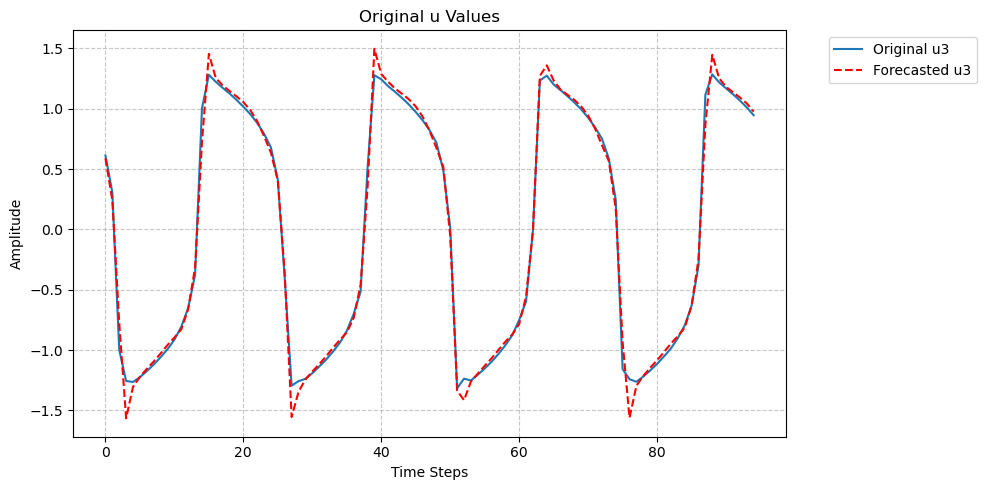

In [22]:

Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=3,
    time_steps=200,
    var_name='u',
    title='Original u Values'
)


In [23]:
x_error, y_error = DataHandler.create_error_sequences(model_data = sol , true_data = sol)
model_corrections = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model_corrections.parameters(), lr=0.001)
trained_model_corrections = hybrid_model._train(model_corrections,x_error,y_error,optimizer,epochs = 200 )
forecast = hybrid_model._forecast(trained_model_corrections, x_test, y_test, corrections=True)

Epoch [20/200], Train Loss: 0.0002 
Epoch [40/200], Train Loss: 0.0000 
Epoch [60/200], Train Loss: 0.0000 
Epoch [80/200], Train Loss: 0.0000 
Epoch [100/200], Train Loss: 0.0000 
Epoch [120/200], Train Loss: 0.0000 
Epoch [140/200], Train Loss: 0.0000 
Epoch [160/200], Train Loss: 0.0000 
Epoch [180/200], Train Loss: 0.0000 
Epoch [200/200], Train Loss: 0.0000 


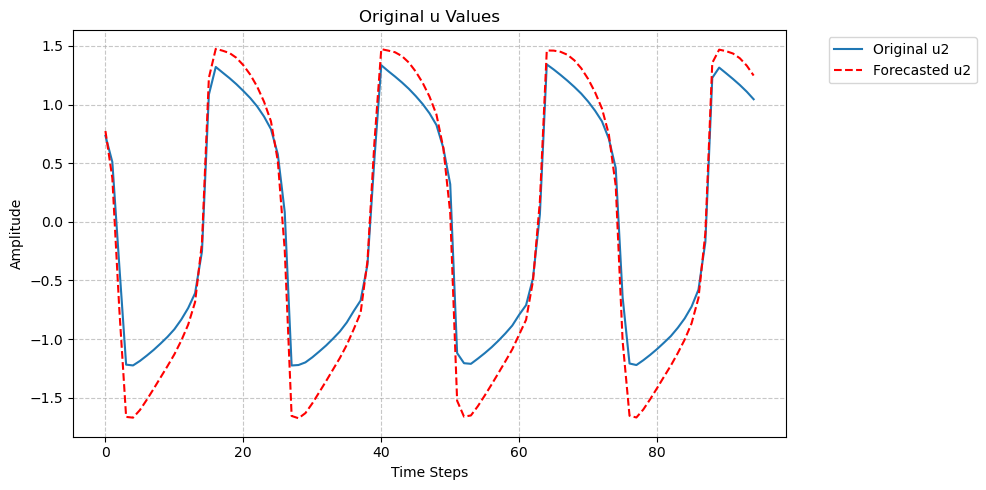

In [24]:

Plotter.plot_data(
    y_test=y_test,
    forecasted=forecast,
    index=2,  # since you were using index 2 in the original code
    time_steps=200,
    var_name='u',
    title='Original u Values'
)

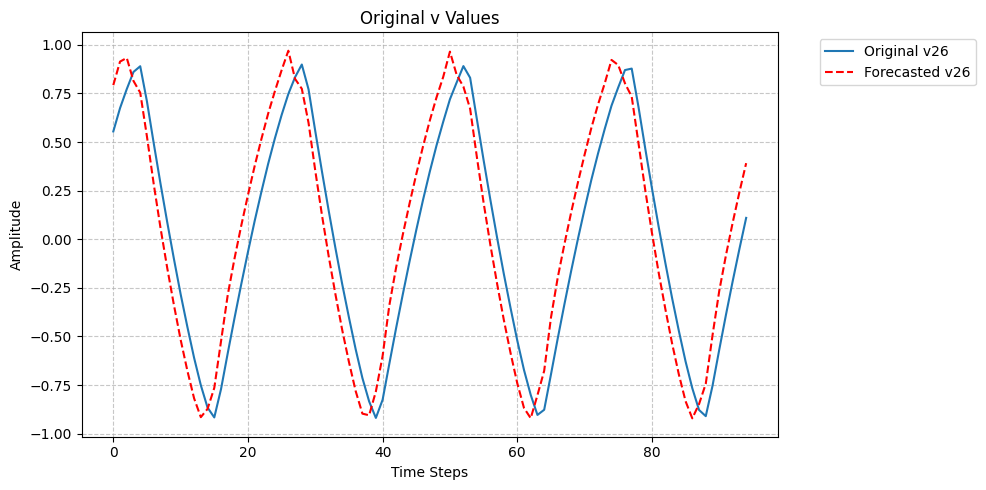

In [112]:

Plotter.plot_data(
    y_test=y_test,
    forecasted=forecast,
    index=26,
    time_steps=200,
    var_name='v',  # Note: changed to 'v' since this plots v variable
    title='Original v Values'  # Also updated title to reflect v variable
)

PEZZO DA CONTROLLARE + classe IZHIKEVIC

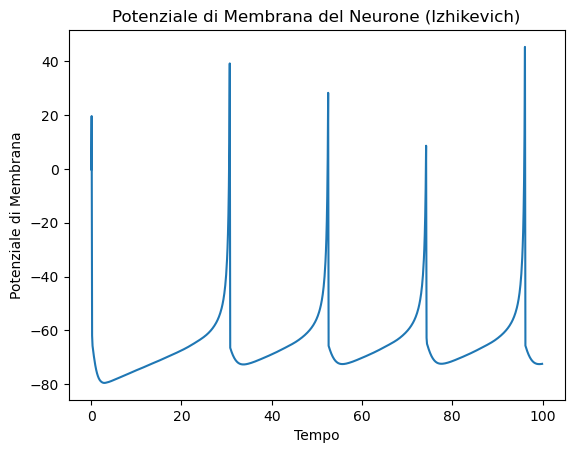

In [25]:


izh_model = izhikevich_model(N=20, a=0.05, b=0.2, c=-65, d=8, I=10)
t, data = izh_model._generate_synthetic_data(T=100, dt=0.1)
hybrid_model = HybridModel()

plt.plot(t, data[:, 1])  
plt.title("Potenziale di Membrana del Neurone (Izhikevich)")
plt.xlabel("Tempo")
plt.ylabel("Potenziale di Membrana")
plt.show()

In [27]:

x,y = DataHandler._prepare_data(data)
x_train, y_train, x_test, y_test = DataHandler._split_train_test(x,y)

In [28]:
model = hybrid_model._create_gru(len(data[1]),len(data[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.1)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 200 )
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)

Epoch [20/200], Train Loss: 0.2242 
Epoch [40/200], Train Loss: 0.1030 
Epoch [60/200], Train Loss: 0.0725 
Epoch [80/200], Train Loss: 0.0609 
Epoch [100/200], Train Loss: 0.0537 
Epoch [120/200], Train Loss: 0.0479 
Epoch [140/200], Train Loss: 0.0433 
Epoch [160/200], Train Loss: 0.0402 
Epoch [180/200], Train Loss: 0.0362 
Epoch [200/200], Train Loss: 0.0330 


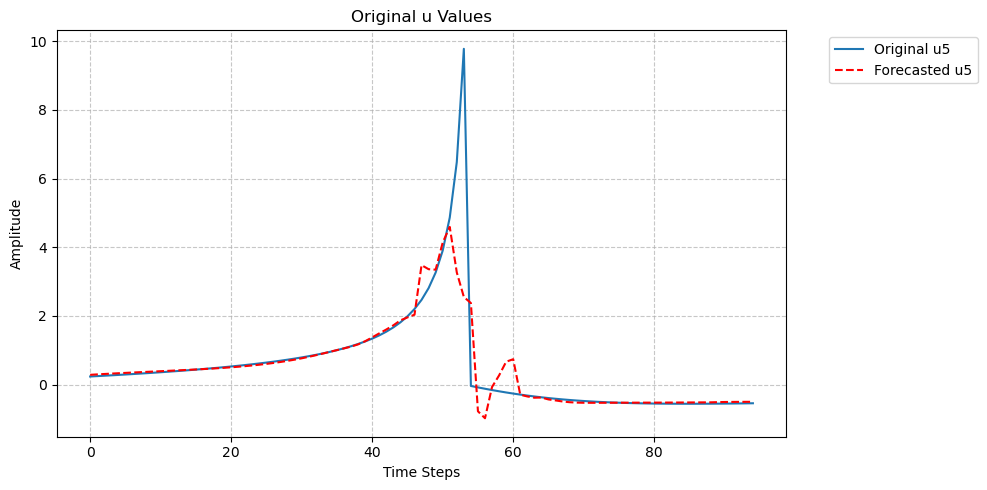

In [29]:

Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=5,
    time_steps=y_test.shape[0],  # Using full length since no slice was specified
    var_name='u',
    title='Original u Values'
)


Da capire se mettere tutte le variabili perchè è più bellino o creare l'oggetto con le variabili di default. 
Nota: le costanti specifiche dei modelli nella rispettiva classe, mentre quelle globali (numero di neuroni), nel file delle costanti.

In [182]:
lif_model = LifModel()
t, V = lif_model.simulate(T=200, dt=0.1)

Da Togliere?

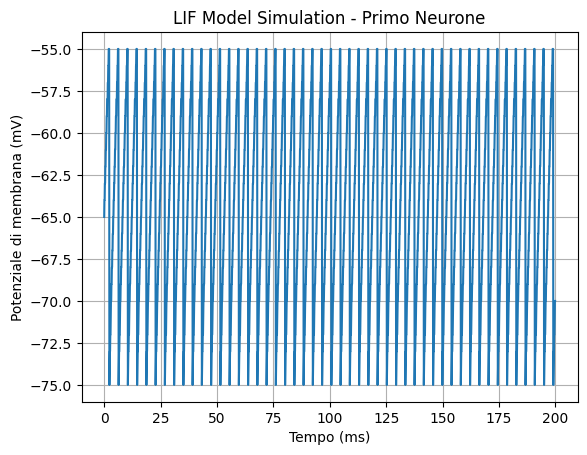

In [183]:
import matplotlib.pyplot as plt

plt.plot(t, V[:, 0])  # Visualizziamo il primo neurone
plt.title("LIF Model Simulation - Primo Neurone")
plt.xlabel("Tempo (ms)")
plt.ylabel("Potenziale di membrana (mV)")
plt.grid()
plt.show()

In [184]:

x, y = DataHandler._prepare_data(V)
x_train, y_train, x_test, y_test = DataHandler._split_train_test(x, y)

In [185]:
model = hybrid_model._create_gru(
    input_size=V.shape[1],  # number of neurons (20 in this case)
    output_size=V.shape[1], 
    same_size=True
)

# Setup optimizer and train
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = hybrid_model._train(model, x_train, y_train, optimizer, epochs=200)

# Generate forecasts
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)

Epoch [20/200], Train Loss: 0.2416 
Epoch [40/200], Train Loss: 0.2186 
Epoch [60/200], Train Loss: 0.1706 
Epoch [80/200], Train Loss: 0.1562 
Epoch [100/200], Train Loss: 0.1022 
Epoch [120/200], Train Loss: 0.0305 
Epoch [140/200], Train Loss: 0.0958 
Epoch [160/200], Train Loss: 0.0168 
Epoch [180/200], Train Loss: 0.0039 
Epoch [200/200], Train Loss: 0.0027 


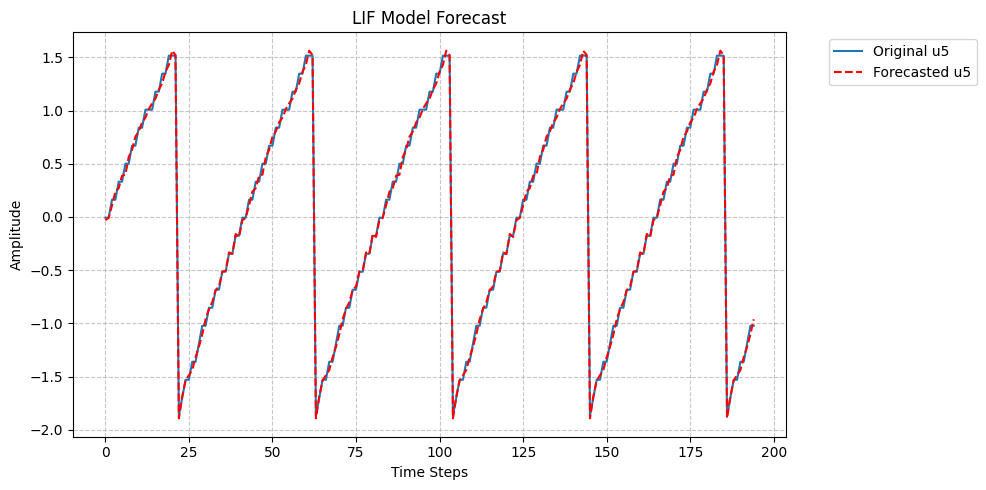

In [186]:
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=5,
    time_steps=y_test.shape[0],
    var_name='u',
    title='LIF Model Forecast'
)

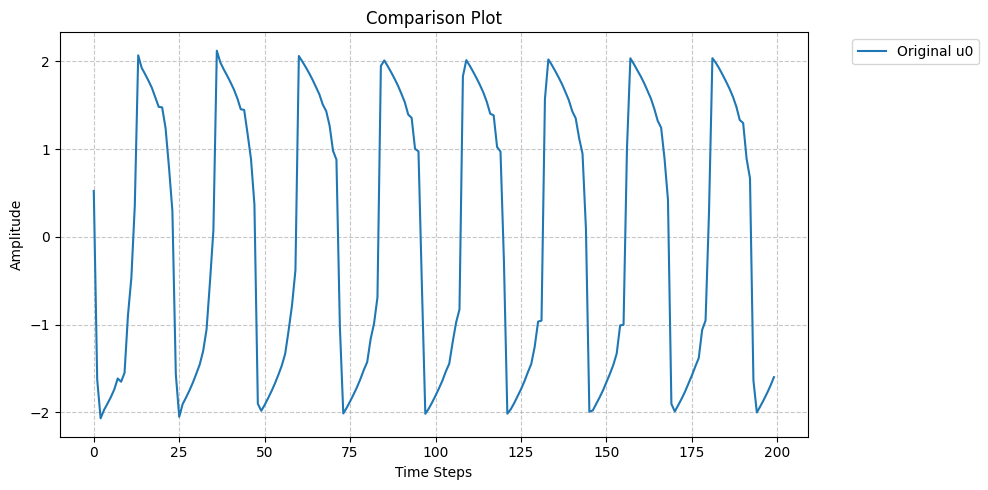

In [122]:

Plotter.plot_data(sol, num_series = 1)